# GeoPandas

Global Historical Climatology Network (GHCN): 2005-2015 New York Region

The data comes from http://www.ncdc.noaa.gov/cdo-web/datasets 

Air Temperature: (tenths of degrees Celsius)
* MNTM - Monthly mean temperature
* MMNT - Monthly Mean minimum temperature
* MMXT - Monthly Mean maximum temperature
* EMNT - Extreme minimum daily temperature
* EMXT - Extreme maximum daily temperature
    
Precipitation: (tenths of mm)
* TPCP - Total precipitation
* EMXP - Extreme maximum daily precipitation 
    
Snow: (mm)
* TSNW - Total snow fall
* MXSD - Maximum snow depth
    


In [79]:
# load pandas
import pandas as pd
import numpy as np

import geopandas as gpd
print(gpd.__version__)

import matplotlib
%matplotlib inline

0.3.0


In [80]:
# load in csv file of data and put it into the ghcn dataframe object
ghcn = pd.read_csv("data/nyc_2005_2015.csv")

In [81]:
#view the first 5 rows of the data
ghcn.head()

,STATION_NAME,DATE,EMXP,MXSD,TPCP,TSNW,EMXT,EMNT,MMXT,MMNT,MNTM
0,NEW YORK J F KENNEDY INTERNATIONAL AIRPORT NY US,20050601,152,0,528,0,350,117,260,173,217
1,NEW YORK J F KENNEDY INTERNATIONAL AIRPORT NY US,20050701,439,0,1324,0,333,161,283,205,244
2,NEW YORK J F KENNEDY INTERNATIONAL AIRPORT NY US,20050801,104,0,148,0,356,178,300,215,257
3,NEW YORK J F KENNEDY INTERNATIONAL AIRPORT NY US,20050901,429,0,548,0,322,100,270,175,223
4,NEW YORK J F KENNEDY INTERNATIONAL AIRPORT NY US,20051001,1184,0,3803,0,244,33,177,108,142


In [82]:
# convert the DATE values into datetime objects
# DATE is in '%Y%m%d' format
# store the parsed dates in the new date column
ghcn['date'] = pd.to_datetime(ghcn['DATE'],format='%Y%m%d')

In [83]:
# use isin to filter for values in a list
stations = ['NEW YORK CENTRAL PARK OBS BELVEDERE TOWER NY US',
            'NEW YORK J F KENNEDY INTERNATIONAL AIRPORT NY US', 
            'NEW YORK LAGUARDIA AIRPORT NY US']
# store subset in nyc dataframe
nyc = ghcn[ghcn['STATION_NAME'].isin(stations)].copy()


In [84]:
# geographic locations of stations
coords = pd.read_csv('data/stations_list.csv')
coords

,datacoverage,elevation,elevationUnit,id,latitude,longitude,maxdate,mindate,name
0,0.9996,39.6,METERS,GHCND:USW00094728,40.7889,-73.9669,7/14/17,1869-01-01,"NY CITY CENTRAL PARK, NY US"
1,0.9999,3.4,METERS,GHCND:USW00014732,40.7792,-73.8800,7/16/17,10/7/39,"LA GUARDIA AIRPORT, NY US"
2,0.8741,3.4,METERS,GHCND:USW00094789,40.6386,-73.7622,7/16/17,7/17/48,"JFK INTERNATIONAL AIRPORT, NY US"


In [85]:
# build a mapping between the names of the stations in each file
name_map = dict(zip(stations,coords['name'].tolist()))
name_map

{'NEW YORK CENTRAL PARK OBS BELVEDERE TOWER NY US': 'NY CITY CENTRAL PARK, NY US',
 'NEW YORK J F KENNEDY INTERNATIONAL AIRPORT NY US': 'LA GUARDIA AIRPORT, NY US',
 'NEW YORK LAGUARDIA AIRPORT NY US': 'JFK INTERNATIONAL AIRPORT, NY US'}

In [86]:
# rename the stations so that they're the same across both files
nyc['STATION_NAME'].replace(name_map, inplace=True)

In [87]:
# merge the two csvs based on the station names (supports most sql merge types)
nycgeo = nyc.merge(coords[['name','latitude', 'longitude']], 
                   left_on = 'STATION_NAME', right_on='name')
# remove redundant columns
nycgeo.drop(columns=['name', 'DATE'],inplace=True)
nycgeo.head()

,STATION_NAME,EMXP,MXSD,TPCP,TSNW,EMXT,EMNT,MMXT,MMNT,MNTM,date,latitude,longitude
0,"LA GUARDIA AIRPORT, NY US",152,0,528,0,350,117,260,173,217,2005-06-01,40.7792,-73.88
1,"LA GUARDIA AIRPORT, NY US",439,0,1324,0,333,161,283,205,244,2005-07-01,40.7792,-73.88
2,"LA GUARDIA AIRPORT, NY US",104,0,148,0,356,178,300,215,257,2005-08-01,40.7792,-73.88
3,"LA GUARDIA AIRPORT, NY US",429,0,548,0,322,100,270,175,223,2005-09-01,40.7792,-73.88
4,"LA GUARDIA AIRPORT, NY US",1184,0,3803,0,244,33,177,108,142,2005-10-01,40.7792,-73.88


In [88]:
# use shapely to convert strings to geometric objects
import shapely.geometry as sgeo

nycgeo['geometry'] = nycgeo.apply(lambda row: 
                                  sgeo.Point(row['longitude'], row['latitude']), axis=1)

nycgeo.drop(columns=['latitude', 'longitude'], inplace=True)

nycgeo.head()

,STATION_NAME,EMXP,MXSD,TPCP,TSNW,EMXT,EMNT,MMXT,MMNT,MNTM,date,geometry
0,"LA GUARDIA AIRPORT, NY US",152,0,528,0,350,117,260,173,217,2005-06-01,POINT (-73.88 40.7792)
1,"LA GUARDIA AIRPORT, NY US",439,0,1324,0,333,161,283,205,244,2005-07-01,POINT (-73.88 40.7792)
2,"LA GUARDIA AIRPORT, NY US",104,0,148,0,356,178,300,215,257,2005-08-01,POINT (-73.88 40.7792)
3,"LA GUARDIA AIRPORT, NY US",429,0,548,0,322,100,270,175,223,2005-09-01,POINT (-73.88 40.7792)
4,"LA GUARDIA AIRPORT, NY US",1184,0,3803,0,244,33,177,108,142,2005-10-01,POINT (-73.88 40.7792)


In [89]:
# convert the pandas dataframe with geometric objects into a geopandas dataframe
crs = {'init': 'epsg:4326'}
ghcn_nyc = gpd.GeoDataFrame(nycgeo, crs=crs)

In [90]:
# load in a shape file to explain where the stations are geographically
coord_system = {'init': 'epsg:4326'}
tracts = gpd.GeoDataFrame.from_file("data/census_tracts/census2010.shp", crs=coord_system)

In [91]:
# the shapefile is loaded into a dataframe
tracts.head()

,ntacode,ctlabel,cdeligibil,shape_leng,ntaname,boro_name,boro_ct201,shape_area,boro_code,ct2010,puma,geometry
0,SI22,9,I,7729.016794,West New Brighton-New Brighton-St. George,Staten Island,5000900,2.497010e+06,5,000900,3903,POLYGON ((-74.07920577013245 40.64343078374567...
1,MN19,98,I,5534.199811,Turtle Bay-East Midtown,Manhattan,1009800,1.906016e+06,1,009800,3808,POLYGON ((-73.96432543478758 40.75638153099091...
2,MN19,100,I,5692.168737,Turtle Bay-East Midtown,Manhattan,1010000,1.860938e+06,1,010000,3808,POLYGON ((-73.96802436915851 40.75957814005282...
3,MN17,102,I,5687.802439,Midtown-Midtown South,Manhattan,1010200,1.860993e+06,1,010200,3807,POLYGON ((-73.97124277307127 40.76093641847906...
4,MN17,104,I,5693.036367,Midtown-Midtown South,Manhattan,1010400,1.864600e+06,1,010400,3807,POLYGON ((-73.97445730550224 40.76229308352487...


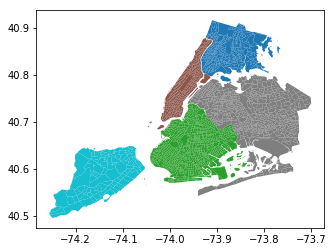

In [92]:
# plot the shapefile as a sanity check
# specifically plot the boro_name column
tracts.plot('boro_name')

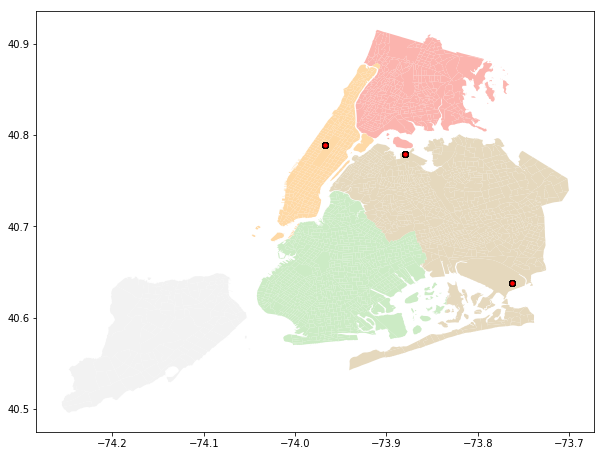

In [93]:
import matplotlib.pyplot as plt
# create a figure  
fig, ax = plt.subplots(figsize=(10,10))
# plot the locations of the stations
ghcn_nyc.plot(ax=ax, marker='o', color='red', edgecolor='black', markersize=30, zorder=10)
# plot takes many of the matplotlib keywords
tracts.plot('boro_name', ax=ax, cmap='Pastel1')
ax.set_aspect("equal")

In [94]:
#compute distance from station to each tract
distances = tracts.apply(lambda row: 
                         ghcn_nyc['geometry'].distance(row['geometry'].centroid), axis=1)

In [95]:
# Find the station closest to each tract
# .values returns the array/matrix of values
stationID = np.argmin(distances.values,axis=1)
# create a new column in station that contains the name of the closest station
tracts['station'] = nycgeo.iloc[stationID]['STATION_NAME'].values

In [97]:
# create a column of min distances 
tracts['distances'] = distances.min(axis=1)

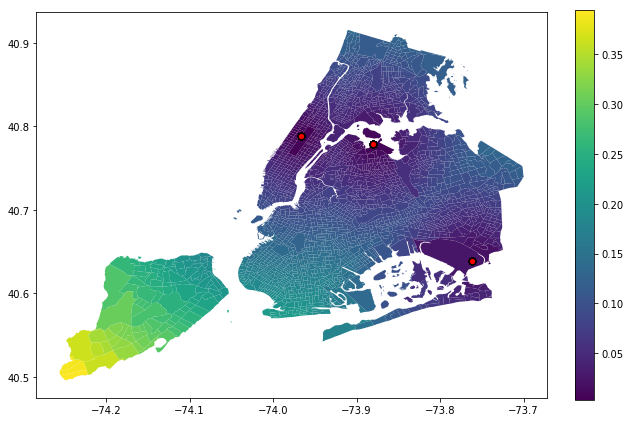

In [98]:
import matplotlib.colors as mcolors
import matplotlib.cm as mcm
norm = mcolors.Normalize(vmin=0, vmax=.4)
cmap = 'viridis'

fig, ax = plt.subplots(figsize=(10,10))

ghcn_nyc.plot(ax=ax, marker='o', color='red', edgecolor='black', markersize=40, zorder=10)
tracts.plot('distances', ax=ax, cmap=cmap, norm=norm)

ax.set_aspect("equal")
# Create a colorbar - because polygons are being plotted, 
# create a fake "image" on which to lay the colorbar
# must use same cmap/norm as in the plot
sm = mcm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
fig.colorbar(sm, ax=ax, fraction=.035)


In [99]:
# geographical aggregation - in this case aggregate up using the 'boro_name' column
boros = tracts.dissolve(by='boro_name', aggfunc='max')

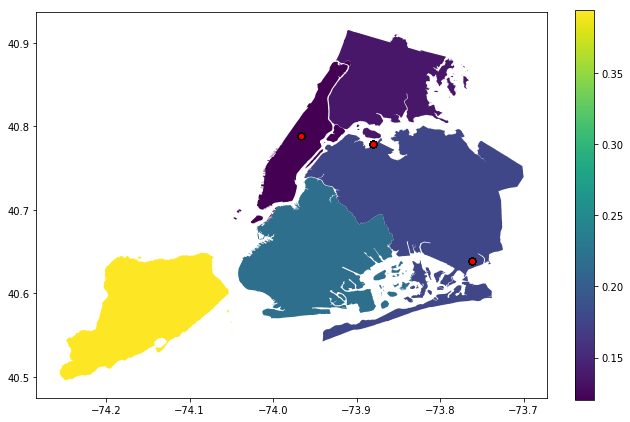

In [33]:
fig, ax = plt.subplots(figsize=(10,10))

ghcn_nyc.plot(ax=ax, marker='o', color='red', edgecolor='black', markersize=40, zorder=10)
boros.plot('distances', ax=ax, cmap=cmap, norm=norm)

ax.set_aspect("equal")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
fig.colorbar(sm, ax=ax, fraction=.035)

In [100]:
# use a spatial join to find all the tracts that contain stations
tracts_with_stations = gpd.sjoin(tracts, ghcn_nyc, how="inner", op='contains')

In [101]:
tracts_with_stations.reset_index(inplace=True)

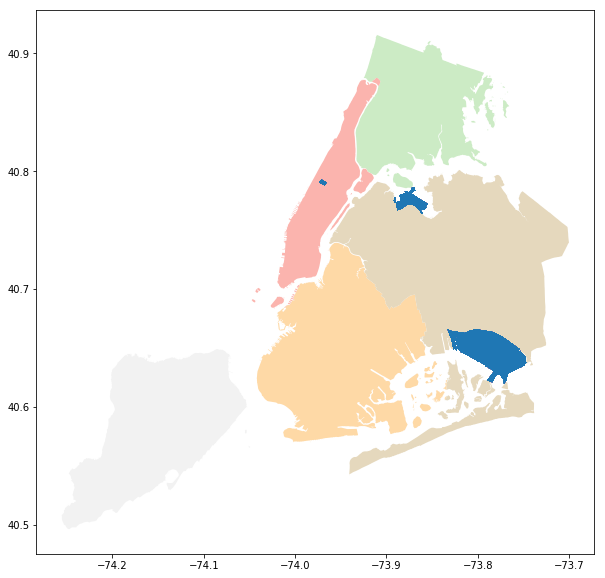

In [102]:
fig, ax = plt.subplots(figsize=(10,10))

boros.plot('boro_code', ax=ax, cmap='Pastel1')
tracts_with_stations.plot(ax=ax)


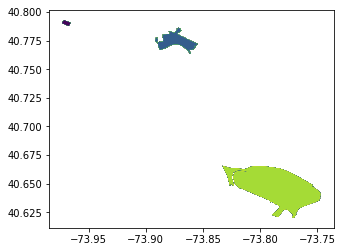

In [103]:
tracts_with_stations.plot('MMNT')

In [71]:
tracts_ghcn = tracts.merge(ghcn_nyc[['STATION_NAME', 'MNTM']], 
                          right_on="STATION_NAME", left_on = "station")

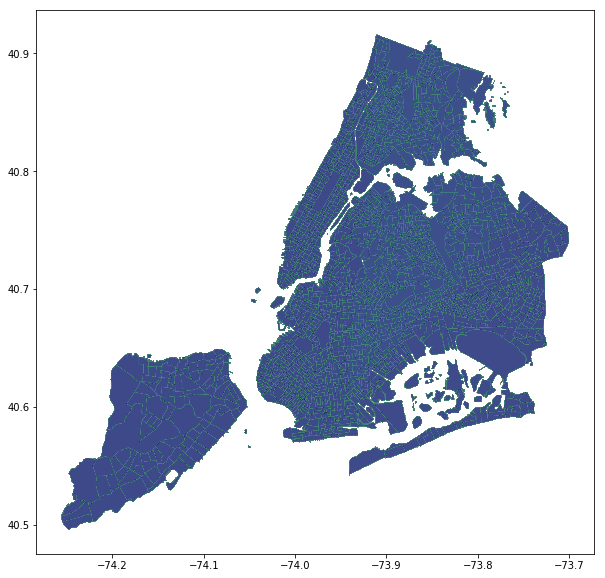

In [75]:
fig, ax = plt.subplots(figsize=(10,10))
tracts_ghcn['MNTM10'] = tracts_ghcn['MNTM']/10
tracts_ghcn.plot("MNTM10", ax=ax, vmin=-2.5, vmax=30)

# Acknowledgements
* Software Carpentary tutorial: https://github.com/story645/ccny_software_carpentary/blob/master/afternoon_session.ipynb

GeoPandas suggestions:
* Paul Hobson (Geosyntec Consultants)
* Tahir Butt (The Graduate Center (CUNY)/Digital Fellows (Graduate Center Digital Initiatives)